# Reforge — Benchmark v2: Analysis

Comprehensive analysis of the LLM function-naming benchmark results.

### Thesis Contributions
1. **Primary**: Ground-truth confidence as a confounding variable  
   — Does GOLD vs SILVER vs BRONZE tier affect apparent model performance?
2. **Context ablation**: Does more Ghidra structural data help?  
   — L0 (code-only) vs L1 (+calls) vs L2 (+calls+CFG+vars)
3. **Optimization decay**: Naming quality degradation O0 → O3  
   — Same `dwarf_function_id` across optimization levels
4. **Model ranking**: 13 models compared on identical data

### Metrics
- **Exact match** (normalised): case/separator insensitive
- **Token F1**: precision/recall on tokenised name components
- **Trivial rate**: proportion of non-informative predictions
- *(Planned)* Embedding cosine similarity, LLM-as-judge

## §1 — Setup

In [5]:
import sys, os, json, warnings
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

REFORGE_ROOT = Path(".").resolve().parent
if str(REFORGE_ROOT) not in sys.path:
    sys.path.insert(0, str(REFORGE_ROOT))

import requests

API = "http://localhost:8080"
def api(path, **kw): return requests.get(f"{API}{path}", **kw).json()

# Plot style
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["savefig.dpi"] = 200
plt.rcParams["figure.figsize"] = (12, 5)

FIGURES_DIR = REFORGE_ROOT / "figures" / "benchmark_v2"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"API: {api('/health')}")
print(f"Figures: {FIGURES_DIR}")

API: {'status': 'healthy', 'service': 'reforge-api', 'version': '0.1.0'}
Figures: C:\Users\nico_\Documents\UNI\Thesis\Source\reforge\figures\benchmark_v2


## §2 — Load All Benchmark Results

In [6]:
# Fetch all benchmark experiments
all_exps = api("/data/experiments")
bench_exps = [e for e in all_exps if "benchmark-v2" in e.get("tags", [])]
print(f"Benchmark experiments: {len(bench_exps)}")

if not bench_exps:
    print("⚠️  No benchmark-v2 experiments found on the API server.")
    print("   Run experiment_config.ipynb §3 (matrix build + register) first,")
    print("   or re-register after an API restart.")

# Fetch scored results for each
all_scores = []
missing = []

for e in bench_exps:
    exp_id = e["id"]
    try:
        resp = api(f"/results/{exp_id}/scores")
        scores = resp.get("rows", []) if isinstance(resp, dict) else resp
        if scores:
            for s in scores:
                s["experiment_id"] = exp_id
                s["model"] = e["model"]
                s["context_level"] = e.get("context_level", "L0")
                s["tier_config"] = e.get("tier", "GOLD")
                s["opt_config"] = e.get("opt", "O0")
            all_scores.extend(scores)
        else:
            missing.append(exp_id)
    except Exception:
        missing.append(exp_id)

df = pd.DataFrame(all_scores)
print(f"Total scored rows: {len(df)}")
print(f"Experiments with no results: {len(missing)}")
if missing:
    print(f"  Missing (first 10): {missing[:10]}")
    print("  → Did you run POST /results/{{exp_id}}/score for these?")

if len(df) > 0:
    print(f"\nColumns: {list(df.columns)}")
    print(f"Models:  {sorted(df['model'].unique())}")
    print(f"Context: {sorted(df['context_level'].unique())}")
    print(f"Tiers:   {sorted(df['tier_config'].unique())}")
    print(f"Opts:    {sorted(df['opt_config'].unique())}")

Benchmark experiments: 4
Total scored rows: 488
Experiments with no results: 0

Columns: ['experiment_id', 'run_id', 'job_id', 'timestamp', 'test_case', 'opt', 'dwarf_function_id', 'ghidra_func_id', 'model', 'prompt_template_id', 'temperature', 'prompt_text', 'response_text', 'prompt_tokens', 'completion_tokens', 'total_tokens', 'latency_ms', 'ground_truth_name', 'predicted_name', 'metadata', 'exact_match_norm', 'token_precision', 'token_recall', 'token_f1', 'is_trivial_prediction', 'scorer_version', 'predicted_tokens', 'ground_truth_tokens', 'context_level', 'tier_config', 'opt_config']
Models:  ['openai/gpt-4o-mini']
Context: ['L2']
Tiers:   ['GOLD']
Opts:    ['O0', 'O1', 'O2', 'O3']


In [7]:
# ── Derive helper columns ─────────────────────────────────────────────────
if len(df) > 0:
    # Short model label for plots
    df["model_short"] = df["model"].str.split("/").str[-1]
    
    # Ensure numeric types
    for col in ["token_f1", "token_precision", "token_recall"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    
    if "exact_match_norm" in df.columns:
        df["exact_match_norm"] = df["exact_match_norm"].astype(bool)
    
    if "is_trivial_prediction" in df.columns:
        df["is_trivial_prediction"] = df["is_trivial_prediction"].astype(bool)
    
    # Confidence tier from GT join (if scorer populated it)
    if "confidence_tier" not in df.columns:
        df["confidence_tier"] = df["tier_config"]
    
    print(f"Ready: {len(df)} rows, {df['model_short'].nunique()} models")
else:
    print("⚠️  No data — run experiments first (see experiment_config.ipynb)")

Ready: 488 rows, 1 models


## §3 — Overall Model Ranking

Aggregate performance across all tiers, opts, and context levels.

               n  mean_f1  mean_precision  mean_recall  exact_match_rate  trivial_rate
model_short                                                                           
gpt-4o-mini  488   0.1618          0.1371       0.2092            0.0246           0.0


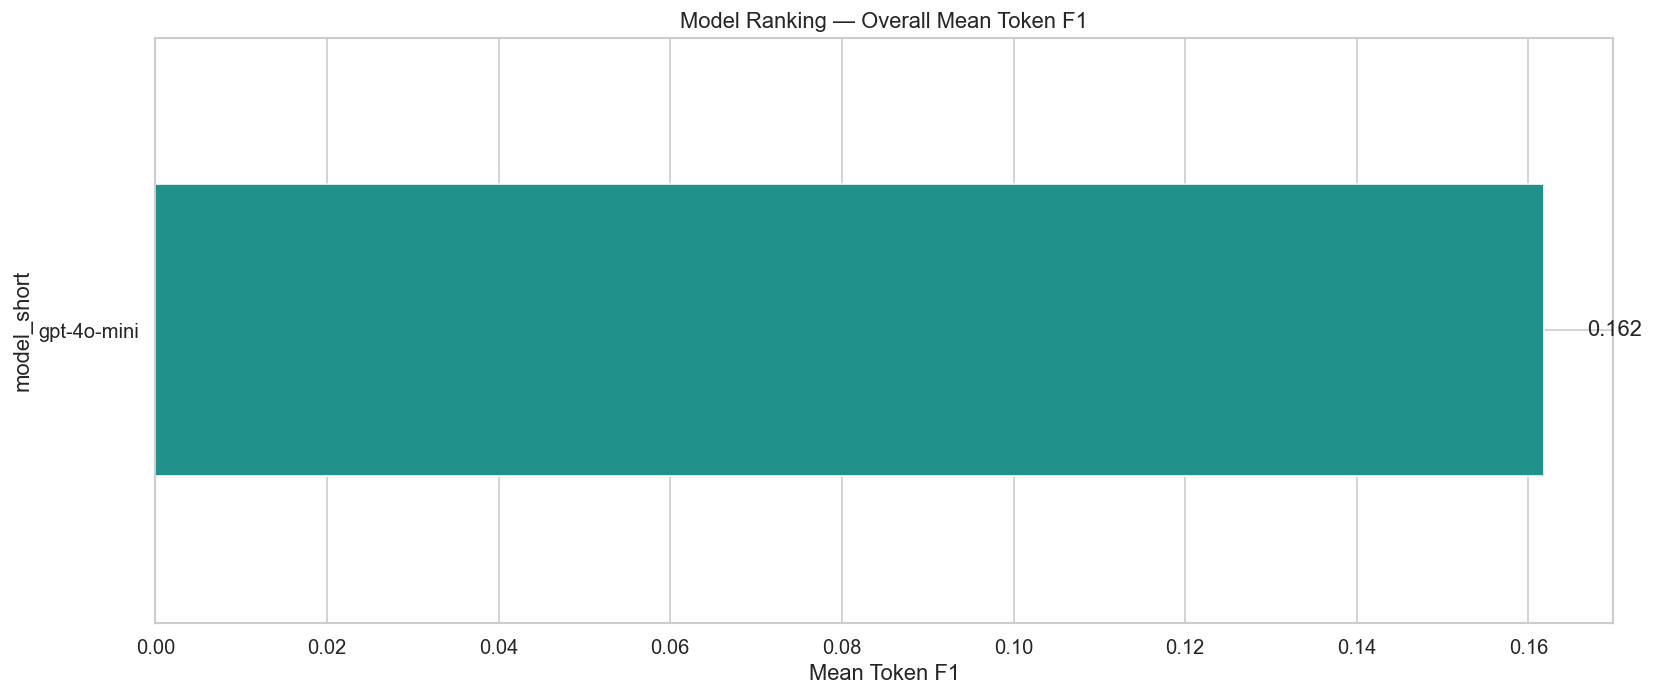

In [8]:
if len(df) > 0:
    ranking = (
        df.groupby("model_short")
        .agg(
            n=("token_f1", "count"),
            mean_f1=("token_f1", "mean"),
            mean_precision=("token_precision", "mean"),
            mean_recall=("token_recall", "mean"),
            exact_match_rate=("exact_match_norm", "mean"),
            trivial_rate=("is_trivial_prediction", "mean"),
        )
        .sort_values("mean_f1", ascending=False)
        .round(4)
    )
    print(ranking.to_string())
    
    # Bar chart
    fig, ax = plt.subplots(figsize=(14, 6))
    ranking["mean_f1"].plot.barh(ax=ax, color=sns.color_palette("viridis", len(ranking)))
    ax.set_xlabel("Mean Token F1")
    ax.set_title("Model Ranking — Overall Mean Token F1")
    ax.invert_yaxis()
    for i, (idx, row) in enumerate(ranking.iterrows()):
        ax.text(row["mean_f1"] + 0.005, i, f"{row['mean_f1']:.3f}", va="center")
    plt.tight_layout()
    fig.savefig(FIGURES_DIR / "model_ranking_f1.png")
    plt.show()
else:
    print("No data available")

## §4 — Context Ablation: Does More Ghidra Data Help?

Compare L0 (code-only) vs L1 (+calls) vs L2 (+calls+CFG+vars) across models.

In [ ]:
if len(df) > 0 and df["context_level"].nunique() > 1:
    ctx_agg = (
        df.groupby(["model_short", "context_level"])
        .agg(n=("token_f1", "count"), mean_f1=("token_f1", "mean"))
        .reset_index()
    )
    
    # Pivot for heatmap
    pivot = ctx_agg.pivot(index="model_short", columns="context_level", values="mean_f1")
    pivot = pivot.reindex(columns=["L0", "L1", "L2"])
    
    # Compute deltas
    if "L0" in pivot.columns and "L2" in pivot.columns:
        pivot["Δ(L2−L0)"] = pivot["L2"] - pivot["L0"]
        pivot = pivot.sort_values("Δ(L2−L0)", ascending=False)
    
    print(pivot.round(4).to_string())
    
    # Grouped bar chart
    fig, ax = plt.subplots(figsize=(14, 6))
    ctx_agg_plot = ctx_agg.pivot(index="model_short", columns="context_level", values="mean_f1")
    ctx_agg_plot = ctx_agg_plot.reindex(columns=["L0", "L1", "L2"])
    ctx_agg_plot.plot.bar(ax=ax, width=0.8)
    ax.set_ylabel("Mean Token F1")
    ax.set_title("Context Ablation: L0 vs L1 vs L2 by Model")
    ax.set_xlabel("")
    ax.legend(title="Context Level")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    fig.savefig(FIGURES_DIR / "context_ablation.png")
    plt.show()
    
    # Heatmap
    fig, ax = plt.subplots(figsize=(8, 10))
    plot_cols = [c for c in ["L0", "L1", "L2"] if c in pivot.columns]
    sns.heatmap(pivot[plot_cols], annot=True, fmt=".3f", cmap="YlGnBu", ax=ax)
    ax.set_title("Mean Token F1 — Context Level × Model")
    plt.tight_layout()
    fig.savefig(FIGURES_DIR / "context_ablation_heatmap.png")
    plt.show()
else:
    print("Need multiple context levels for ablation analysis")

## §5 — Ground-Truth Confidence as Confounding Variable

**Primary thesis contribution.**  
If GOLD-tier functions systematically score higher than SILVER/BRONZE,  
then GT confidence is a confound that affects model evaluation.

In [9]:
if len(df) > 0 and "confidence_tier" in df.columns and df["confidence_tier"].nunique() > 1:
    tier_agg = (
        df.groupby(["model_short", "confidence_tier"])
        .agg(
            n=("token_f1", "count"),
            mean_f1=("token_f1", "mean"),
            exact_match_rate=("exact_match_norm", "mean"),
        )
        .reset_index()
    )
    
    # Overall tier effect (averaged across models)
    tier_overall = (
        df.groupby("confidence_tier")
        .agg(
            n=("token_f1", "count"),
            mean_f1=("token_f1", "mean"),
            std_f1=("token_f1", "std"),
            exact_match_rate=("exact_match_norm", "mean"),
        )
        .round(4)
    )
    print("Overall by Confidence Tier:")
    print(tier_overall.to_string())
    print()
    
    # Box plot: F1 distribution by tier
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    tier_order = ["GOLD", "SILVER", "BRONZE"]
    available_tiers = [t for t in tier_order if t in df["confidence_tier"].values]
    
    sns.boxplot(data=df, x="confidence_tier", y="token_f1",
                order=available_tiers, ax=axes[0], palette="Set2")
    axes[0].set_title("Token F1 Distribution by GT Confidence Tier")
    axes[0].set_xlabel("Confidence Tier")
    axes[0].set_ylabel("Token F1")
    
    # Paired: tier × model heatmap
    pivot_tier = tier_agg.pivot(index="model_short", columns="confidence_tier", values="mean_f1")
    pivot_tier = pivot_tier.reindex(columns=available_tiers)
    sns.heatmap(pivot_tier, annot=True, fmt=".3f", cmap="RdYlGn", ax=axes[1])
    axes[1].set_title("Mean F1: Tier × Model")
    
    plt.tight_layout()
    fig.savefig(FIGURES_DIR / "gt_confidence_confound.png")
    plt.show()
    
    # Statistical test: Kruskal-Wallis (non-parametric ANOVA)
    from scipy import stats
    groups = [df.loc[df["confidence_tier"] == t, "token_f1"].dropna() for t in available_tiers]
    groups = [g for g in groups if len(g) > 0]
    if len(groups) >= 2:
        stat, pval = stats.kruskal(*groups)
        print(f"\nKruskal-Wallis test (F1 ~ tier): H={stat:.2f}, p={pval:.2e}")
        if pval < 0.05:
            print("→ Significant: GT confidence tier DOES affect apparent performance.")
            print("  This is a confounding variable in decompilation benchmarks.")
        else:
            print("→ Not significant at α=0.05")
else:
    print("Need multiple tiers for confound analysis")

Need multiple tiers for confound analysis


## §6 — Optimization Decay: O0 → O3

Same functions (linked by `dwarf_function_id`) across optimization levels.  
Measures how compilation optimization degrades decompilation quality.

Overall by Optimization Level:
              n  mean_f1  std_f1  exact_match_rate  trivial_rate
opt_config                                                      
O0          196   0.1914  0.2681            0.0306           0.0
O1          115   0.1543  0.2587            0.0261           0.0
O2           92   0.1349  0.2314            0.0217           0.0
O3           85   0.1328  0.2264            0.0118           0.0



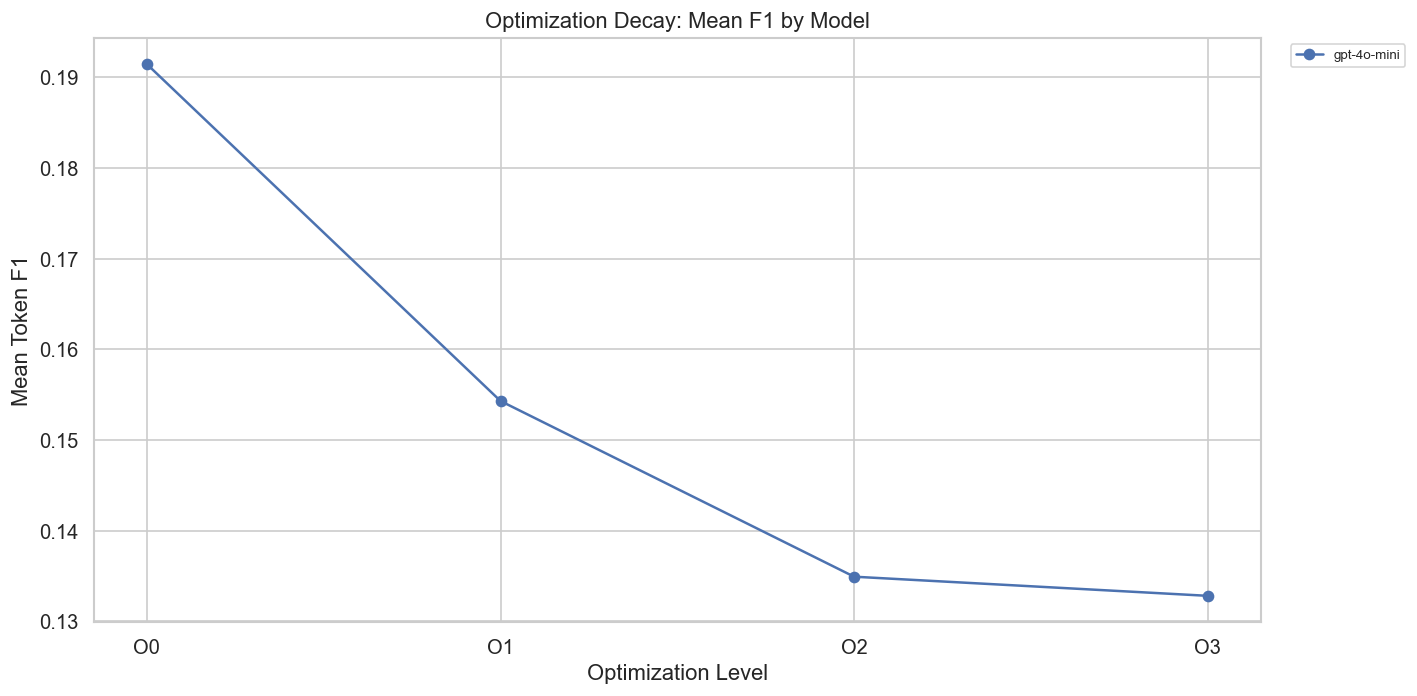


Δ(O3−O0) per model:
opt_config       O0      O1      O2      O3  Δ(O3−O0)
model_short                                          
gpt-4o-mini  0.1914  0.1543  0.1349  0.1328   -0.0586


In [10]:
if len(df) > 0 and df["opt_config"].nunique() > 1:
    opt_agg = (
        df.groupby(["model_short", "opt_config"])
        .agg(
            n=("token_f1", "count"),
            mean_f1=("token_f1", "mean"),
            exact_match_rate=("exact_match_norm", "mean"),
        )
        .reset_index()
    )
    
    # Overall opt effect
    opt_overall = (
        df.groupby("opt_config")
        .agg(
            n=("token_f1", "count"),
            mean_f1=("token_f1", "mean"),
            std_f1=("token_f1", "std"),
            exact_match_rate=("exact_match_norm", "mean"),
            trivial_rate=("is_trivial_prediction", "mean"),
        )
        .round(4)
    )
    print("Overall by Optimization Level:")
    print(opt_overall.to_string())
    print()
    
    # Line plot: F1 vs opt level per model
    fig, ax = plt.subplots(figsize=(12, 6))
    opt_order = ["O0", "O1", "O2", "O3"]
    for model_name, grp in opt_agg.groupby("model_short"):
        grp = grp.set_index("opt_config").reindex(opt_order)
        ax.plot(opt_order, grp["mean_f1"], marker="o", label=model_name)
    
    ax.set_xlabel("Optimization Level")
    ax.set_ylabel("Mean Token F1")
    ax.set_title("Optimization Decay: Mean F1 by Model")
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8)
    plt.tight_layout()
    fig.savefig(FIGURES_DIR / "optimization_decay.png")
    plt.show()
    
    # Δ(O0→O3) per model
    if all(o in df["opt_config"].values for o in ["O0", "O3"]):
        delta_opt = (
            opt_agg.pivot(index="model_short", columns="opt_config", values="mean_f1")
            .reindex(columns=opt_order)
        )
        delta_opt["Δ(O3−O0)"] = delta_opt["O3"] - delta_opt["O0"]
        delta_opt = delta_opt.sort_values("Δ(O3−O0)")
        print("\nΔ(O3−O0) per model:")
        print(delta_opt.round(4).to_string())
else:
    print("Need multiple opt levels for decay analysis")

## §7 — Per-Function Optimization Decay (Paired Analysis)

Link the SAME function across O0/O1/O2/O3 via `dwarf_function_id`.

In [11]:
if len(df) > 0 and "dwarf_function_id" in df.columns and df["opt_config"].nunique() > 1:
    # For one model at L0 context, do paired comparison
    model_for_paired = df["model_short"].value_counts().index[0]  # most data
    paired_df = df[(df["model_short"] == model_for_paired) & (df["context_level"] == "L0")].copy()
    
    if len(paired_df) > 0:
        # Pivot: each row = one dwarf_function_id, columns = O0..O3 F1
        paired_pivot = paired_df.pivot_table(
            index="dwarf_function_id",
            columns="opt_config",
            values="token_f1",
            aggfunc="first",
        )
        
        # Keep only functions present in multiple opts
        paired_pivot = paired_pivot.dropna(thresh=2)
        print(f"Paired functions for {model_for_paired}: {len(paired_pivot)}")
        
        if "O0" in paired_pivot.columns and "O3" in paired_pivot.columns:
            both = paired_pivot[["O0", "O3"]].dropna()
            both["delta"] = both["O3"] - both["O0"]
            
            print(f"Functions with O0+O3: {len(both)}")
            print(f"Mean Δ(O3-O0): {both['delta'].mean():.4f}")
            print(f"Median Δ:      {both['delta'].median():.4f}")
            print(f"Functions degraded (Δ<-0.1): {(both['delta'] < -0.1).sum()}")
            print(f"Functions improved (Δ>+0.1): {(both['delta'] > 0.1).sum()}")
            
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            axes[0].hist(both["delta"], bins=30, edgecolor="white")
            axes[0].axvline(0, color="red", linestyle="--")
            axes[0].set_title(f"Paired Δ(O3−O0) Token F1 — {model_for_paired}")
            axes[0].set_xlabel("Δ Token F1")
            
            axes[1].scatter(both["O0"], both["O3"], alpha=0.3, s=10)
            lims = [0, 1]
            axes[1].plot(lims, lims, "r--", alpha=0.5)
            axes[1].set_xlabel("F1 at O0")
            axes[1].set_ylabel("F1 at O3")
            axes[1].set_title("O0 vs O3 Token F1 (per function)")
            axes[1].set_aspect("equal")
            
            plt.tight_layout()
            fig.savefig(FIGURES_DIR / "paired_opt_decay.png")
            plt.show()
            
            # Wilcoxon signed-rank test
            from scipy import stats
            stat, pval = stats.wilcoxon(both["O0"], both["O3"])
            print(f"\nWilcoxon signed-rank: W={stat:.0f}, p={pval:.2e}")
            if pval < 0.05:
                print("→ Significant difference between O0 and O3 performance")
else:
    print("Need data with dwarf_function_id across multiple opts")

## §8 — Quality Weight Analysis

Does the continuous quality weight (oracle confidence score) predict F1?

In [12]:
if len(df) > 0 and "quality_weight" in df.columns:
    qw_df = df[df["quality_weight"].notna()].copy()
    qw_df["quality_weight"] = pd.to_numeric(qw_df["quality_weight"], errors="coerce")
    qw_df = qw_df.dropna(subset=["quality_weight", "token_f1"])
    
    if len(qw_df) > 100:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Scatter: QW vs F1
        axes[0].scatter(qw_df["quality_weight"], qw_df["token_f1"], alpha=0.1, s=5)
        axes[0].set_xlabel("Quality Weight")
        axes[0].set_ylabel("Token F1")
        axes[0].set_title("Quality Weight vs Token F1")
        
        # Binned mean
        qw_df["qw_bin"] = pd.cut(qw_df["quality_weight"], bins=10)
        binned = qw_df.groupby("qw_bin", observed=True).agg(
            mean_f1=("token_f1", "mean"),
            n=("token_f1", "count"),
        ).reset_index()
        binned["qw_mid"] = binned["qw_bin"].apply(lambda x: x.mid)
        
        axes[1].bar(range(len(binned)), binned["mean_f1"], tick_label=[f"{x:.2f}" for x in binned["qw_mid"]])
        axes[1].set_xlabel("Quality Weight (bin midpoint)")
        axes[1].set_ylabel("Mean Token F1")
        axes[1].set_title("Binned Quality Weight vs Mean F1")
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        fig.savefig(FIGURES_DIR / "quality_weight_analysis.png")
        plt.show()
        
        # Correlation
        from scipy import stats
        r, p = stats.spearmanr(qw_df["quality_weight"], qw_df["token_f1"])
        print(f"Spearman correlation (QW × F1): r={r:.4f}, p={p:.2e}")
    else:
        print(f"Only {len(qw_df)} rows with quality_weight — need more data")
else:
    print("quality_weight not available in results")

quality_weight not available in results


## §9 — Per-Test-Case Performance

Which test case types are hardest for LLMs to name?

                           n  mean_f1  std_f1  exact_match_rate
test_case                                                      
t02_shared_header_macros  10   0.4886  0.4123            0.2000
t01_crossfile_calls       29   0.4053  0.3124            0.0690
t08_loop_heavy            55   0.2895  0.3602            0.1455
t09_string_format         29   0.2207  0.2096            0.0000
t05_fptr_callbacks        39   0.2076  0.2146            0.0000
t13_goto_labels           16   0.2042  0.2237            0.0000
t14_anon_aggregates       32   0.1757  0.2331            0.0000
t06_recursion_inline      12   0.1722  0.2609            0.0000
t03_header_dominant        7   0.1293  0.2312            0.0000
t10_math_libm             37   0.1225  0.2835            0.0000
t04_static_dup_names      20   0.1036  0.2198            0.0000
t11_mixed_stress          56   0.0844  0.1486            0.0000
t12_state_machine         76   0.0789  0.1444            0.0000
t07_switch_parser         34   0.0633  0

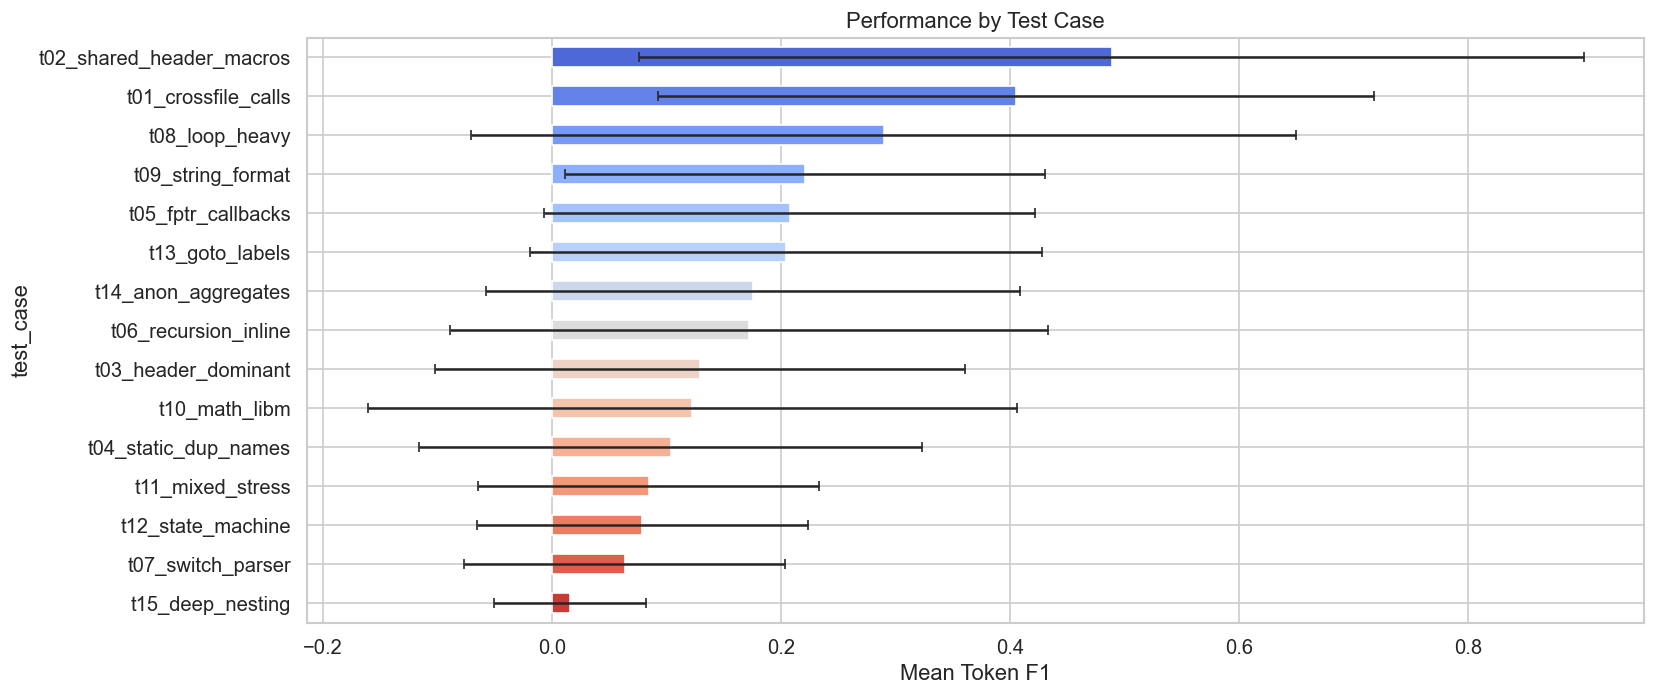

In [13]:
if len(df) > 0 and "test_case" in df.columns:
    tc_agg = (
        df.groupby("test_case")
        .agg(
            n=("token_f1", "count"),
            mean_f1=("token_f1", "mean"),
            std_f1=("token_f1", "std"),
            exact_match_rate=("exact_match_norm", "mean"),
        )
        .sort_values("mean_f1", ascending=False)
        .round(4)
    )
    print(tc_agg.to_string())
    
    if len(tc_agg) > 1:
        fig, ax = plt.subplots(figsize=(14, 6))
        tc_agg["mean_f1"].plot.barh(ax=ax, xerr=tc_agg["std_f1"], capsize=3,
                                     color=sns.color_palette("coolwarm", len(tc_agg)))
        ax.set_xlabel("Mean Token F1")
        ax.set_title("Performance by Test Case")
        ax.invert_yaxis()
        plt.tight_layout()
        fig.savefig(FIGURES_DIR / "test_case_performance.png")
        plt.show()
else:
    print("No test_case data")

## §10 — Interaction Effects: Context × Tier × Opt

Three-way interaction to check if context level benefit varies by tier or opt.

In [14]:
if len(df) > 0 and df["context_level"].nunique() > 1 and df["confidence_tier"].nunique() > 1:
    interaction = (
        df.groupby(["context_level", "confidence_tier", "opt_config"])
        .agg(n=("token_f1", "count"), mean_f1=("token_f1", "mean"))
        .reset_index()
    )
    
    # Faceted: one subplot per opt level
    opt_levels = sorted(interaction["opt_config"].unique())
    n_opts = len(opt_levels)
    fig, axes = plt.subplots(1, n_opts, figsize=(5 * n_opts, 5), sharey=True)
    if n_opts == 1:
        axes = [axes]
    
    for ax, opt_lvl in zip(axes, opt_levels):
        sub = interaction[interaction["opt_config"] == opt_lvl]
        pivot = sub.pivot(index="confidence_tier", columns="context_level", values="mean_f1")
        pivot = pivot.reindex(index=["GOLD", "SILVER", "BRONZE"], columns=["L0", "L1", "L2"])
        pivot.plot.bar(ax=ax, width=0.7)
        ax.set_title(f"Opt: {opt_lvl}")
        ax.set_ylabel("Mean F1" if ax == axes[0] else "")
        ax.set_xlabel("")
        ax.legend(title="Context", fontsize=8)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
    fig.suptitle("Context × Tier × Opt Interaction", fontsize=14, y=1.02)
    plt.tight_layout()
    fig.savefig(FIGURES_DIR / "interaction_ctx_tier_opt.png", bbox_inches="tight")
    plt.show()
else:
    print("Need multiple context levels and tiers for interaction analysis")

Need multiple context levels and tiers for interaction analysis


## §11 — Latency & Cost Analysis

In [ ]:
if len(df) > 0 and "latency_ms" in df.columns:
    df["latency_ms"] = pd.to_numeric(df["latency_ms"], errors="coerce")
    df["total_tokens"] = pd.to_numeric(df.get("total_tokens", 0), errors="coerce")
    
    latency_agg = (
        df.groupby("model_short")
        .agg(
            n=("latency_ms", "count"),
            mean_latency_ms=("latency_ms", "mean"),
            p50_latency_ms=("latency_ms", "median"),
            p95_latency_ms=("latency_ms", lambda x: x.quantile(0.95)),
            mean_tokens=("total_tokens", "mean"),
        )
        .sort_values("mean_latency_ms")
        .round(0)
    )
    print(latency_agg.to_string())
    
    # Quality vs Speed scatter
    model_perf = df.groupby("model_short").agg(
        mean_f1=("token_f1", "mean"),
        mean_latency=("latency_ms", "mean"),
    ).reset_index()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(model_perf["mean_latency"], model_perf["mean_f1"], s=80)
    for _, row in model_perf.iterrows():
        ax.annotate(row["model_short"], (row["mean_latency"], row["mean_f1"]),
                    textcoords="offset points", xytext=(5, 5), fontsize=8)
    ax.set_xlabel("Mean Latency (ms)")
    ax.set_ylabel("Mean Token F1")
    ax.set_title("Quality vs Speed: Model Pareto Front")
    plt.tight_layout()
    fig.savefig(FIGURES_DIR / "quality_vs_speed.png")
    plt.show()
else:
    print("No latency data")

## §12 — Leak-Proof Assertion

Verify that no ground-truth information leaked into LLM inputs.

In [ ]:
from data.llm_contract import validate_no_leakage, FORBIDDEN_KEYS

# Sample some raw function records
sample_fns = api("/llm/functions", params={"opt": "O0", "tier": "GOLD", "limit": 50, "context_level": "L2"})

violations = 0
for fn in sample_fns:
    leaked = validate_no_leakage(fn)
    if leaked:
        print(f"  ❌ LEAK: {fn.get('dwarf_function_id', '?')}: {leaked}")
        violations += 1

if violations == 0:
    print(f"✅ LEAK-PROOF: {len(sample_fns)} functions checked at L2 context — zero GT fields")
    print(f"   Forbidden keys blocked: {len(FORBIDDEN_KEYS)}")
else:
    print(f"❌ {violations} VIOLATIONS DETECTED — fix immediately")

## §13 — Summary Statistics for Thesis

Export-ready numbers for the thesis results chapter.

In [15]:
if len(df) > 0:
    print("=" * 60)
    print("BENCHMARK v2 — SUMMARY STATISTICS")
    print("=" * 60)
    print(f"Total scored predictions:  {len(df):,}")
    print(f"Models evaluated:          {df['model_short'].nunique()}")
    print(f"Context levels:            {sorted(df['context_level'].unique())}")
    print(f"Confidence tiers:          {sorted(df['confidence_tier'].unique()) if 'confidence_tier' in df.columns else 'N/A'}")
    print(f"Optimization levels:       {sorted(df['opt_config'].unique())}")
    print(f"Test cases:                {df['test_case'].nunique() if 'test_case' in df.columns else 'N/A'}")
    print()
    print(f"Overall Mean Token F1:     {df['token_f1'].mean():.4f} ± {df['token_f1'].std():.4f}")
    print(f"Overall Exact Match Rate:  {df['exact_match_norm'].mean():.4f}")
    print(f"Overall Trivial Rate:      {df['is_trivial_prediction'].mean():.4f}")
    print()
    
    # Best model
    best = df.groupby("model_short")["token_f1"].mean().idxmax()
    best_f1 = df.groupby("model_short")["token_f1"].mean().max()
    print(f"Best model:                {best} (F1={best_f1:.4f})")
    
    # Context ablation effect
    if df["context_level"].nunique() > 1:
        ctx_means = df.groupby("context_level")["token_f1"].mean()
        if "L0" in ctx_means and "L2" in ctx_means:
            delta = ctx_means["L2"] - ctx_means["L0"]
            print(f"Context effect (L2−L0):    {delta:+.4f}")
    
    # Opt decay
    if df["opt_config"].nunique() > 1:
        opt_means = df.groupby("opt_config")["token_f1"].mean()
        if "O0" in opt_means and "O3" in opt_means:
            decay = opt_means["O3"] - opt_means["O0"]
            print(f"Opt decay (O3−O0):         {decay:+.4f}")
    
    print("\n" + "=" * 60)
else:
    print("No data — run experiments first")

BENCHMARK v2 — SUMMARY STATISTICS
Total scored predictions:  488
Models evaluated:          1
Context levels:            ['L2']
Confidence tiers:          ['GOLD']
Optimization levels:       ['O0', 'O1', 'O2', 'O3']
Test cases:                15

Overall Mean Token F1:     0.1618 ± 0.2528
Overall Exact Match Rate:  0.0246
Overall Trivial Rate:      0.0000

Best model:                gpt-4o-mini (F1=0.1618)
Opt decay (O3−O0):         -0.0586



---

### Figures saved to
`reforge/figures/benchmark_v2/`

### Next steps
- Embedding cosine similarity (sentence-transformers)
- LLM-as-judge validation sample (~100 rows)
- LaTeX table export for thesis